## 1. Cài đặt thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import datetime
from datetime import timedelta
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 2. Tiền xử lý dữ liệu

In [2]:
split_ratio = '70_15_15'
base_path = '/Users/nhxtrxng/Desktop/PTDLKD/IS403.P23-Gold/Dataset/Splits'
train_df = pd.read_csv(os.path.join(base_path, f'train_{split_ratio}.csv'))
val_df = pd.read_csv(os.path.join(base_path, f'val_{split_ratio}.csv'))
test_df = pd.read_csv(os.path.join(base_path, f'test_{split_ratio}.csv'))

full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
full_df['Date'] = pd.to_datetime(full_df['Date'])
for col in ['Price', 'Open', 'High', 'Low']:
    full_df[col] = full_df[col].str.replace(',', '').astype(float)
full_df['Change %'] = full_df['Change %'].str.replace('%', '').astype(float)

def parse_volume(val):
    if isinstance(val, str):
        if val.endswith('K'):
            return float(val[:-1]) * 1e3
        elif val.endswith('M'):
            return float(val[:-1]) * 1e6
        else:
            return float(val)
    return np.nan
full_df['Vol.'] = full_df['Vol.'].apply(parse_volume)
mean_vol = full_df['Vol.'].mean()
full_df['Vol.'].fillna(mean_vol, inplace=True)
full_df = full_df.dropna().sort_values('Date').reset_index(drop=True)


## 3. Tạo dữ liệu với timestep = 90

In [3]:
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'CPIAUCSL']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(full_df[features])

X, y = [], []
timestep = 90
for i in range(timestep, len(scaled_data)):
    X.append(scaled_data[i - timestep:i])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

n_train = len(train_df) - timestep
n_val = len(val_df)
n_test = len(test_df)

X_train = X[:n_train]
y_train = y[:n_train]
X_val = X[n_train:n_train + n_val]
y_val = y[n_train:n_train + n_val]
X_test = X[n_train + n_val:n_train + n_val + n_test]
y_test = y[n_train + n_val:n_train + n_val + n_test]

# KHÁC: Định dạng cho CNN-LSTM là (samples, time, features)
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_val_torch = torch.tensor(X_val, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

## 4. Dataset và DataLoader

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train_torch, y_train_torch)
test_ds = TimeSeriesDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

## 5. Mô hình CNN-LSTM

In [5]:
class CNN_LSTM(nn.Module):
    def __init__(self, n_features, seq_len, cnn_out=64, lstm_hidden=64):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=cnn_out, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(cnn_out)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=cnn_out, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: [batch, time, features]
        x = x.permute(0, 2, 1)  # [batch, features, time] cho Conv1d
        x = self.relu(self.bn1(self.conv1(x)))  # [batch, cnn_out, time]
        x = x.permute(0, 2, 1)  # [batch, time, cnn_out] cho LSTM
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Lấy output của step cuối cùng

model = CNN_LSTM(n_features=X_train_torch.shape[2], seq_len=timestep)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## 6. Huấn luyện mô hình

In [6]:
epochs = 30
for epoch in range(epochs):
    model.train()
    train_losses = []
    for Xb, yb in train_loader:
        preds = model(Xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss = {np.mean(train_losses):.4f}")


Epoch 1: Train Loss = 0.0025
Epoch 2: Train Loss = 0.0004
Epoch 3: Train Loss = 0.0002
Epoch 4: Train Loss = 0.0003
Epoch 5: Train Loss = 0.0002
Epoch 6: Train Loss = 0.0001
Epoch 7: Train Loss = 0.0001
Epoch 8: Train Loss = 0.0001
Epoch 9: Train Loss = 0.0001
Epoch 10: Train Loss = 0.0001
Epoch 11: Train Loss = 0.0001
Epoch 12: Train Loss = 0.0001
Epoch 13: Train Loss = 0.0001
Epoch 14: Train Loss = 0.0001
Epoch 15: Train Loss = 0.0001
Epoch 16: Train Loss = 0.0001
Epoch 17: Train Loss = 0.0001
Epoch 18: Train Loss = 0.0001
Epoch 19: Train Loss = 0.0001
Epoch 20: Train Loss = 0.0001
Epoch 21: Train Loss = 0.0001
Epoch 22: Train Loss = 0.0001
Epoch 23: Train Loss = 0.0001
Epoch 24: Train Loss = 0.0001
Epoch 25: Train Loss = 0.0001
Epoch 26: Train Loss = 0.0001
Epoch 27: Train Loss = 0.0001
Epoch 28: Train Loss = 0.0001
Epoch 29: Train Loss = 0.0001
Epoch 30: Train Loss = 0.0001


## 7. Dự đoán và đánh giá

In [7]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_torch).squeeze().numpy()

# MAE
mae = mean_absolute_error(y_test, y_pred)

# MAPE (tránh chia cho 0)
mape = np.mean(np.abs((y_test - y_pred) / np.clip(np.abs(y_test), 1e-8, None))) * 100

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R^2
r2 = r2_score(y_test, y_pred)

# Adjusted R^2
n = len(y_test)
p = X_test.shape[2]  # số lượng feature đầu vào (không phải timestep)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")


MAE: 0.0739
MAPE: 10.16%
RMSE: 0.1144
R²: 0.5206
Adjusted R²: 0.5148


## 8. Dự báo 90 ngày tiếp theo

In [8]:
def forecast_future_with_details(model, last_sequence, n_future, scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for day in range(n_future):
        current_sequence_reshaped = torch.tensor(current_sequence[np.newaxis, :, :], dtype=torch.float32)
        next_pred = model(current_sequence_reshaped).detach().numpy()
        predicted_price = scaler.inverse_transform(
            np.concatenate([next_pred, np.zeros((1, 6))], axis=1)
        )[0, 0]

        input_prices = scaler.inverse_transform(
            np.concatenate([current_sequence[:, 0].reshape(-1, 1), np.zeros((90, 6))], axis=1)
        )[:, 0]

        print(f"Ngày thứ {day + 1}: Output (giá dự đoán): {predicted_price:.2f} USD")

        future_predictions.append([predicted_price])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1, 0] = next_pred[0, 0]

    return np.array(future_predictions)


## 9. Vẽ biểu đồ kết quả dự đoán

Ngày thứ 1: Output (giá dự đoán): 2414.32 USD
Ngày thứ 2: Output (giá dự đoán): 2300.52 USD
Ngày thứ 3: Output (giá dự đoán): 2235.09 USD
Ngày thứ 4: Output (giá dự đoán): 2245.26 USD
Ngày thứ 5: Output (giá dự đoán): 2258.18 USD
Ngày thứ 6: Output (giá dự đoán): 2205.31 USD
Ngày thứ 7: Output (giá dự đoán): 2217.41 USD
Ngày thứ 8: Output (giá dự đoán): 2246.06 USD
Ngày thứ 9: Output (giá dự đoán): 2276.88 USD
Ngày thứ 10: Output (giá dự đoán): 2262.62 USD
Ngày thứ 11: Output (giá dự đoán): 2271.25 USD
Ngày thứ 12: Output (giá dự đoán): 2274.40 USD
Ngày thứ 13: Output (giá dự đoán): 2260.48 USD
Ngày thứ 14: Output (giá dự đoán): 2270.11 USD
Ngày thứ 15: Output (giá dự đoán): 2278.92 USD
Ngày thứ 16: Output (giá dự đoán): 2287.50 USD
Ngày thứ 17: Output (giá dự đoán): 2298.05 USD
Ngày thứ 18: Output (giá dự đoán): 2273.30 USD
Ngày thứ 19: Output (giá dự đoán): 2264.35 USD
Ngày thứ 20: Output (giá dự đoán): 2268.45 USD
Ngày thứ 21: Output (giá dự đoán): 2268.01 USD
Ngày thứ 22: Output (g

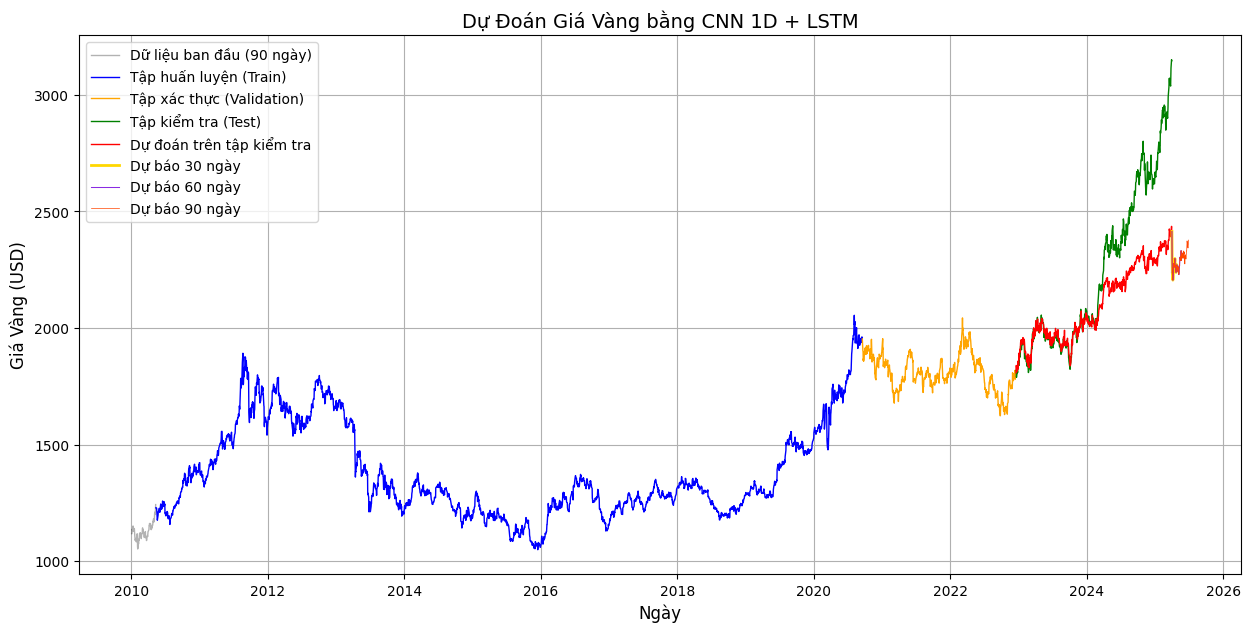

In [9]:
# Dữ liệu thời gian
full_dates = full_df['Date'].reset_index(drop=True)
train_size = len(train_df) - timestep
val_size = len(val_df)
test_size = len(test_df)

train_dates = full_dates[timestep:train_size + timestep]
val_dates = full_dates[train_size + timestep:train_size + val_size + timestep]
test_dates = full_dates[train_size + val_size + timestep:]

# Thực hiện dự đoán tương lai
last_sequence = X[-1]  # lấy sequence cuối cùng sau chuẩn hóa
future_90 = forecast_future_with_details(model, last_sequence, 90, scaler)
future_30 = future_90[:30]
future_60 = future_90[:60]

# Ngày dự báo tương lai
future_dates = pd.date_range(start=full_dates.iloc[-1] + timedelta(days=1), periods=90, freq='D')

# Giá thực tế sau inverse
scaled_prices = scaler.transform(full_df[features])[:, 0]
inv_prices = scaler.inverse_transform(np.c_[scaled_prices.reshape(-1, 1), np.zeros((len(scaled_prices), 6))])[:, 0]

train_prices = inv_prices[timestep:train_size + timestep]
val_prices = inv_prices[train_size + timestep:train_size + val_size + timestep]
test_prices = inv_prices[train_size + val_size + timestep:]

# Dự đoán test tập (y_pred đã tính trước đó)
y_pred_real = scaler.inverse_transform(np.c_[y_pred.reshape(-1, 1), np.zeros((len(y_pred), 6))])[:, 0]

# Vẽ biểu đồ
plt.figure(figsize=(15, 7))
plt.plot(full_dates[:timestep], inv_prices[:timestep], 'k-', label='Dữ liệu ban đầu (90 ngày)', alpha=0.3, linewidth=1.0)
plt.plot(train_dates, train_prices, 'b-', label='Tập huấn luyện (Train)', linewidth=1.0)
plt.plot(val_dates, val_prices, 'orange', label='Tập xác thực (Validation)', linewidth=1.0)
plt.plot(test_dates, test_prices, 'g-', label='Tập kiểm tra (Test)', linewidth=1.0)
plt.plot(test_dates, y_pred_real, 'r-', label='Dự đoán trên tập kiểm tra', linewidth=1.0)
plt.plot(future_dates[:30], future_30, color='#FFD700', label='Dự báo 30 ngày', linewidth=2.0)
plt.plot(future_dates[:60], future_60, color='#8A2BE2', label='Dự báo 60 ngày', linewidth=0.75)
plt.plot(future_dates, future_90, color='#FF4500', label='Dự báo 90 ngày', linewidth=0.5)
plt.title('Dự Đoán Giá Vàng bằng CNN 1D + LSTM', fontsize=14)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá Vàng (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()